# Lake Depth Random Forest model

#### Using:
1. cuDf for data pre-processing
2. cuML for machine learning algorithm implementations
3. Dask for rapids parallelization of GPU code
4. sklearn for metrics

#### Import our model object
Best model is saved

In [1]:
from load_dataset import custom_lakedepth
from models import custom_RF as crf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint

#### Import LakeDepth dataset object
##### Split into training and testing

In [2]:
primary_dataset = custom_lakedepth.LakeDepth(random_state = 42)
covariates_train, covariates_test, labels_train, labels_test = primary_dataset.split(0.20)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


### Random Forest (best model so far) parameters

In [3]:
best_rf_model = crf.load_model('best_test_04.sav')
pprint(best_rf_model.model.get_params())

{'accuracy_metric': 'mean_ae',
 'bootstrap': True,
 'bootstrap_features': False,
 'handle': <cuml.raft.common.handle.Handle object at 0x7f93f3219b90>,
 'max_batch_size': 128,
 'max_depth': 100,
 'max_features': 'sqrt',
 'max_leaves': -1,
 'min_impurity_decrease': 0.0,
 'min_rows_per_node': 2,
 'n_bins': 16,
 'n_estimators': 1621,
 'output_type': 'cudf',
 'quantile_per_tree': False,
 'rows_sample': 1.0,
 'split_algo': 1,
 'split_criterion': 2,
 'use_experimental_backend': False,
 'verbose': 4}


### Training times (w/ Dask Implementation):
#### with max-depth at sub-80
1.        trees < 500  : 01-02 sec training time
2. 500  < trees < 1000 : 03-04 sec training time
3. 100  < trees < 1500 : 04-05 sec training time
5. 1500 < trees < 2000 : 05-12 sec training time

#### with max-depth at 80+
1.        trees < 500  : 03-04 sec training time
2. 500  < trees < 1000 : 04-09 sec training time
3. 100  < trees < 1500 : 09-15 sec training time
5. 1500 < trees < 2000 : 15-25 sec training time

## Metrics
#### measure the models abilities through
1. Mean Absolute Error
2. r2_score
3. Mean Square Error

In [4]:
predictions, mae, r2, mse = best_rf_model.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.3535175
  r2:  0.8700720756140472
 MSE:  0.4495084


-- Still not great on MAE considering the limited range of depths we're working for

## Results Visualization

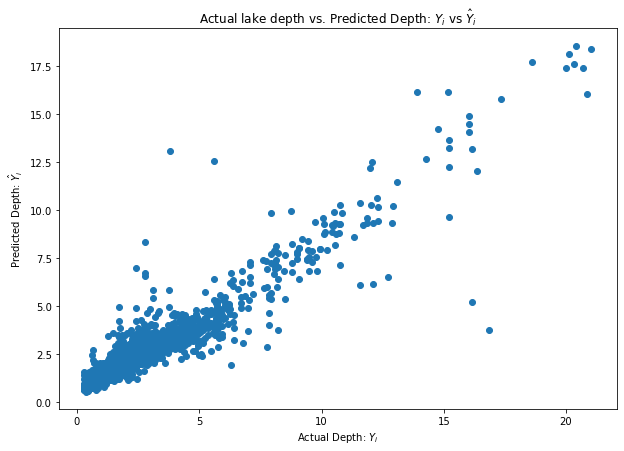

In [5]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling of actual vs predicted data

In [6]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:  3580 Actual:   2.0474600791931152 Predicted:   2.1441352367401123
Data-point:  3480 Actual:    1.730430006980896 Predicted:   1.9948105812072754
Data-point:   321 Actual:   2.8420000076293945 Predicted:    2.784285068511963
Data-point:  4538 Actual:   2.9714300632476807 Predicted:    3.420234203338623
Data-point:   353 Actual:   0.5536670088768005 Predicted:   1.0335729122161865
Data-point:  1705 Actual:   2.0088601112365723 Predicted:   2.5883190631866455
Data-point:  1452 Actual:    4.023079872131348 Predicted:   3.1575756072998047
Data-point:  1145 Actual:    2.127500057220459 Predicted:   2.0353527069091797
Data-point:  1590 Actual:    0.746999979019165 Predicted:   1.2259587049484253
Data-point:   902 Actual:   1.7975000143051147 Predicted:   1.7657151222229004
Data-point:  1417 Actual:   1.7356499433517456 Predicted:   1.7288182973861694
Data-point:  3624 Actual:   3.7795000076293945 Predicted:   3.3195478916168213
Data-point:   555 Actual:   0.6639999747276306 Predi

## Feature Importance

Using sklearn's permutation importance


In [ ]:
best_rf_model.feature_importances(covariates_train, labels_train, show = True)

## Final Points

* Dask combined with cuDF/cuML is still experimental
* We see significant speedups during training time